In [1]:
# Libraries.
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# Setup.
% matplotlib inline

# Paths.
path_data = '../../../data/gatecount_%d/'

In [2]:
#call to read in gate_count with all of the processing from other notebook
gate_count=pd.read_csv('../../../data/gatecount_edit.csv')
gate_count.servicedate = pd.to_datetime(gate_count.servicedate)

#fare_count=pd.read_csv('../../../data/fare_count_edit.csv')

#weather_path = '../../../data/weather/wunderground_daily_weather.csv'

#weather = pd.read_csv(weather_path)
#weather.date = pd.to_datetime(weather.date)

gate_count.head()

,Unnamed: 0,locationid,servicedate,entries,exits,servicetime_frac,weekday,month,cold,date,rain,snow,snowfalli
0,0,1002,2014-01-01,1,0,5.25,2,1,True,2014-01-01 00:00:00,0,0,0
1,1,1002,2014-01-01,8,0,5.50,2,1,True,2014-01-01 00:00:00,0,0,0
2,2,1002,2014-01-01,6,0,5.75,2,1,True,2014-01-01 00:00:00,0,0,0
3,3,1002,2014-01-01,16,3,6.00,2,1,True,2014-01-01 00:00:00,0,0,0
4,4,1002,2014-01-01,17,9,6.25,2,1,True,2014-01-01 00:00:00,0,0,0


In [3]:
gate_stations=gate_count.locationid.unique()

# function to preprocess the station id numbers. Only want to keep the stations that appear in gate_count
def is_in_gate_count(id):
    #print id
    if(len(np.where(gate_stations==id)[0])==0):
        return False
    else :
        return True
    

In [4]:
station_info=pd.read_csv('../../../data/Stations.csv')
# remove rows where line==Nan
station_info=station_info[~station_info['line_temp'].isnull()]
# Take out bus stations
station_info=station_info[station_info['line_temp']!='Bus']
# Take out ids that aren't found in gate_count
station_info=station_info[map(is_in_gate_count,station_info['stationid'].values)]

# Remove some columns
station_info=station_info[['stationid','nameshort','namelong','name','line_temp']]
station_info.head()

,stationid,nameshort,namelong,name,line_temp
20,1002,Andrew Square,1002,Andrew Square,Red
21,1004,JFK/U Mass,1004,JFK/U Mass,Red
22,1005,North Quincy,1005,North Quincy,Red
23,1006,Wollaston,1006,Wollaston,Red
24,1007,Quincy Center,1007,Quincy Center,Red


In [5]:
red_stations=station_info[station_info['line_temp']=='Red']
red_stations_ids=list(red_stations.stationid.values)
# Park is only listed on Green in stations.csv. Want to add it to red because its a junction
red_stations_ids.append(1052)
# Downtown Xing is only listed on Orange in stations.csv. Want to add it to red because its a junction
red_stations_ids.append(1039)
print len(red_stations_ids)


blue_stations=station_info[station_info['line_temp']=='Blue']
blue_stations_ids=list(blue_stations.stationid.values)
# Add govt center junction
blue_stations_ids.append(1051)
# add state st
blue_stations_ids.append(1077)
print len(blue_stations_ids)

green_stations=station_info[station_info['line_temp']=='Green']
green_stations_ids=list(green_stations.stationid.values)
#add haymarket
green_stations_ids.append(1076)
#add north station
green_stations_ids.append(1075)
print len(green_stations_ids)

orange_stations=station_info[station_info['line_temp']=='Orange']
orange_stations_ids=list(orange_stations.stationid.values)
print len(orange_stations_ids)



22
12
14
19


In [6]:
from sklearn import preprocessing

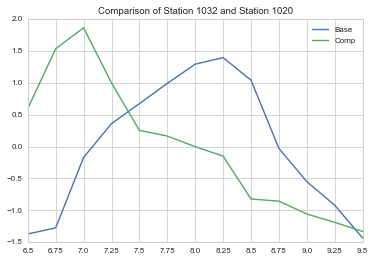

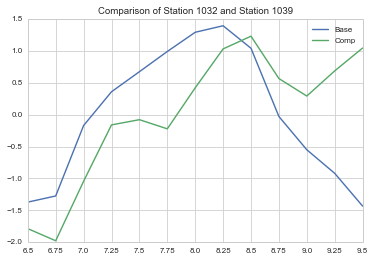

{1002: 0.95116975252367353,
 1004: 0.95293505672123568,
 1005: 0.9915079740813163,
 1006: 0.82840728302882916,
 1007: 0.92178624864830971,
 1009: 0.90853401681658774,
 1020: 0.010804071670300654,
 1032: 1.0000000000000002,
 1033: 0.92593852867355697,
 1034: 0.87162707562536079,
 1035: 0.79021897444483302,
 1036: 0.7288133227306659,
 1037: 0.69716803579121123,
 1039: 0.44428032027480213,
 1040: 0.94546853357508354,
 1041: 0.57327403279567879,
 1042: 0.81681864019031891,
 1043: 0.72255561193754048,
 1052: 0.63779721356776919,
 1103: 0.91998468921784748,
 1112: 0.92571307409331582,
 2106: 0.7313656476745295}

In [18]:
## Want to compare portions of time series across various stations. 

def compare_series(station_id,comparison_station=False,begin_time=4.5,end_time=9.5, print_plot=False):
    
    if(not comparison_station):
        comparison_station=[station_id]
    
    station_records=gate_count[gate_count['weekday']<5]
    station_records=station_records[(station_records['servicetime_frac']<=end_time) & (station_records['servicetime_frac']>=begin_time) ]
    
    #get subset of station
    base_records=station_records[(station_records['locationid']==station_id)]
    base_grouping=base_records[['servicetime_frac','servicedate','entries']].groupby('servicetime_frac')
    base_entries=base_grouping.agg(np.mean)['entries']
    
    # Standardize the entries so we can indentify stations with similar behavior without worrying about scale
    base_entries_scaled=preprocessing.scale(base_entries)
    
    correlations={}
    
    for station in comparison_station:
        
        comp_records=station_records[(station_records['locationid']==station)]
        comp_grouping=comp_records[['servicetime_frac','servicedate','entries']].groupby('servicetime_frac')
        comp_entries=comp_grouping.agg(np.mean)['entries']
        
        comp_entries_scaled=preprocessing.scale(comp_entries)
        
        # np.correlate for two series of the same length returns a correlation which is <= length of the two series
        # since each pairwise comparison of the terms can yield an individual correlation of 1. Want to think of correlation
        # of series from [-1,1] so I divided by the length of the series
        correlations[station]=(np.correlate(base_entries_scaled,comp_entries_scaled)*1.0/len(base_entries_scaled))[0]

        # Print dissimilar stations
        if(print_plot& (correlations[station]<0.45)):
            plt.plot(base_entries_scaled,label='Base')
            plt.plot(comp_entries_scaled,label='Comp')
            plt.title('Comparison of Station '+str(station_id)+' and Station '+str(station))
            plt.legend()
            plt.xticks(range(13), list(comp_entries.index))
            plt.show()
        
        
    return correlations

compare_series(1032,comparison_station=red_stations_ids,begin_time=6.5,end_time=9.5,print_plot=True)

In [19]:
## Example: comparing Alewife and Forest Hills, both of which are terminal stations outside the city with bus connections
# running into them. Would expect similar behavior from the two. 

#sanity check: comparison for station 1032 should be 1.0 since it's the same as our base station
# station 1087: Forest Hills. 1077: State Street. 1052: Park.

all_correlations_1032=compare_series(1032,comparison_station=red_stations_ids+
                                     blue_stations_ids+
                                     green_stations_ids+
                                     orange_stations_ids,
                                     begin_time=5.,end_time=19.5)

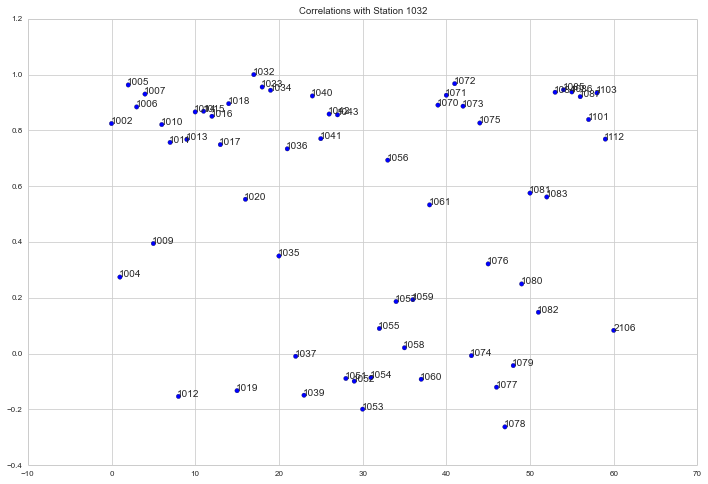

In [9]:
correlations_df=pd.DataFrame(zip(all_correlations_1032.keys(),all_correlations_1032.values()))
correlations_df=correlations_df.sort([0])

labels=list(correlations_df[0].values)
xs=range(len(correlations_df))
ys=list(correlations_df[1].values)

plt.figure(figsize=(12,8))
plt.scatter(xs,ys)
plt.title('Correlations with Station 1032')

for i, txt in enumerate(labels):
    plt.annotate(txt, (i,ys[i]))


In [50]:
'''fig, ax = plt.subplots()
heatmap = ax.pcolor(batter_df[cols],cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()'''
temp_ids=red_stations_ids

temp_ids.sort()

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(output.keys(),output.values()))
    correlations_df=correlations_df.sort([0])

    correlation_vectors.append(list(correlations_df[1].values))
    

1002
1004
1005
1006
1007
1009
1020
1032
1033
1034
1035
1036
1037
1039
1040
1041
1042
1043
1052
1103
1112
2106


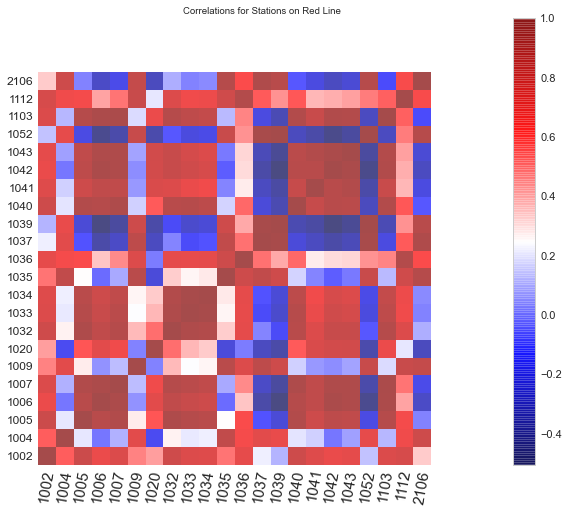

In [68]:

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(10,8)

#ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 

ax.set_xticklabels(temp_ids, minor=False)
ax.set_yticklabels(temp_ids, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Red Line')
colorbar=plt.colorbar(heatmap)

plt.show()

